# Servo simulation draft

Outline for simulating response from two-level ion when driven with a drifting clock laser. Linewidth functions interchangeable.

TODO:
- integrate dead time ($e^{-(t_{meas}/\tau_{ion})}$)
- laser noise & linewidth
- some way to simulate different measurement cycles (LHHL), maybe add an impact on dead time due to servo re-alignment?

In [283]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import peak_widths, find_peaks
from scipy.stats import cauchy, binom

Lineshape function used is the ideal Rabi flopping when driven with pi pulses:
\begin{align}
\rho_{ee}(t) = \left( \frac{\pi}{2} \right)^2 \textrm{sinc}^2 \left( \frac{\sqrt{\pi^2 + \delta^2 t^2}}{2} \right)
\end{align} 

In [400]:
def lineshape(delta, t, tau_pi=6e-3):
    scale = np.pi / tau_pi
    sinc_arg = 0.5 * np.sqrt(np.pi ** 2 + np.square(delta/scale) * np.square(t))
    out = (np.pi/2.)**2 * np.square(np.divide(np.sin(sinc_arg), sinc_arg))
    return out

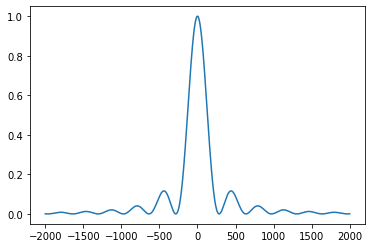

In [401]:
d, step = np.linspace(-2000, 2000, 1000, retstep=True)
plt.plot(d, lineshape(d, 10, 6e-3))

132.07897042119254

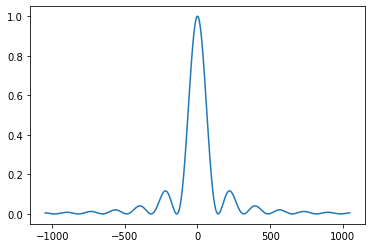

In [366]:
# scaling lineshape
scaling_param = (np.pi / 6e-3)
l_s = lineshape(d, 20)
plt.plot(d * scaling_param, l_s)
widths = peak_widths(l_s, [np.argmax(l_s)], rel_height=0.5)
d[int(np.rint(widths[3][0]))]*scaling_param-d[int(np.rint(widths[2][0]))]*scaling_param

The slope ($k_p(\delta, t)$) is calculated using a simple finite differential scheme from the lineshape. More sophisticated methods could also be used.

-0.020448669688741147

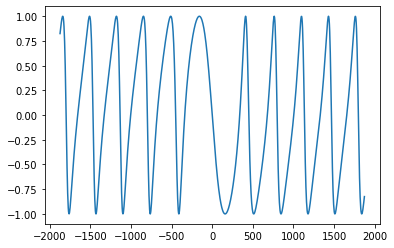

In [387]:
def slope(lineshape_func, delta, t, dlims=(-2, 2), acc=1000):
    assert(delta > dlims[0] and delta < dlims[1]), "Derivative not defined outside range!"
    ds, step = np.linspace(dlims[0], dlims[1], acc, retstep=True)
    lineshape = lineshape_func(ds, t)
    d_ls = np.diff(lineshape) / step
    nearest = np.argmin(np.abs(ds-delta))
    return d_ls[nearest]

def FWHM(lineshape, delta):
    width = peak_widths(lineshape, [np.argmax(lineshape)], rel_height=0.5)
    out = d[int(np.rint(widths[3][0]))] - d[int(np.rint(widths[2][0]))]
    return out

def k_p(lineshape_func, delta, t, tau_pi=6e-3, n=1000):
    fwhm = FWHM(lineshape_func(delta, t, tau_pi), delta)
    d_R = np.linspace(start=delta[0], stop=delta[-1] - fwhm, num=n)
    d_B = d_R + fwhm
    d = d_R + fwhm / 2.
    p_R = lineshape_func(d_R, t, tau_pi)
    p_B = lineshape_func(d_B, t, tau_pi)
    k = np.divide(p_B - p_R, p_B + p_R)
    d_k = np.diff(k) / (d[1] - d[0])
    origin = k[np.argmin(np.abs(d))] 
    return origin, k, d

d, step = np.linspace(-2000, 2000, 1000, retstep=True)
kp, k, d_k = k_p(lineshape, d, 10)
plt.plot(d_k, k)
kp

2000.0

Visualising the result of laser offset on the measured probabilities $p_R$ and $p_B$. Scipy ``peak_widths`` used here to calculate FWHM.

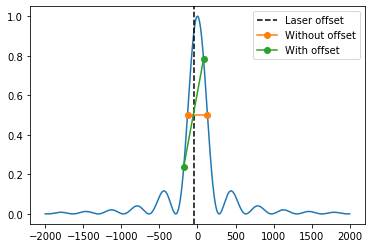

In [404]:
l_s = lineshape(d,10, 6e-3)
widths = peak_widths(l_s, [np.argmax(l_s)], rel_height=0.5)
without_offset = get_both_ps(d, lineshape, 10)
laser_offset = -50
with_offset = get_both_ps(d, lineshape, 10, laser_offset=laser_offset)
plt.plot(d, l_s)
plt.axvline(laser_offset, color='k', linestyle='--', label='Laser offset')
plt.plot([without_offset['x_R'], without_offset['x_B']],[without_offset['p_R'], without_offset['p_B']], marker='o', label='Without offset')
plt.plot([with_offset['x_R'], with_offset['x_B']],[with_offset['p_R'], with_offset['p_B']], marker='o', label='With offset')
plt.legend()

In [397]:
T_s = 5 #s
n_m = 100 #number of measurements per cycle
laser_drift = 20e-6 #Hz/s
def sampling_cycle(f0, T_s, n_m, theoretical_delta, tau_pi=6e-3):
    time_step = T_s / n_m
    detunings = np.arange(start=f0, stop=f0 + n_m * laser_drift * time_step, step = laser_drift * time_step) + theoretical_delta
    jump_probabilities = lineshape(detunings, 10, tau_pi) # quantum jump p from theory
    measured_results = binom.rvs(n=1, p=jump_probabilities) # draws from binomial
    p_X = np.sum(measured_results) / n_m
    return p_X, detunings[-1]
sampling_cycle(0, T_s, 100, FWHM(l_s, d))

(0.02, 252.252351252252)

Simulating a measurement by first finding the detunings $\delta_R$ and $\delta_B$ corresponding to the probability measurements assuming $\epsilon = 0$ (laser frequency exactly at transition frequency) and then offsetting them by the laser offset (compounded from drift, laser noise etc.). New probabilities are then calculated from the linewidth function.

In [277]:
def get_both_ps(d, lineshape_func, t, laser_offset=None):
    l_s =lineshape_func(d, t) # generate lineshape data
    widths = peak_widths(l_s, [np.argmax(l_s)], rel_height=0.5) #get FWMH data
    x_R = d[int(np.rint(widths[2][0]))]
    x_B = d[int(np.rint(widths[3][0]))]
    p_R = p_B = widths[1][0]
    if laser_offset is not None:
        x_R += laser_offset
        x_B += laser_offset
        p_R = lineshape_func(x_R, t)
        p_B = lineshape_func(x_B, t)
    return {'x_R': x_R,
            'x_B': x_B,
            'p_R': p_R,
            'p_B': p_B}

Correction signal
\begin{equation}
E = G \left( \frac{p_B - p_R}{p_B + p_R} \right)
\end{equation}

In [278]:
def correction_signal(gain, measurement_dict):
    p_R = measurement_dict['p_R']
    p_B = measurement_dict['p_B']
    return gain * (p_R - p_B)/(p_B + p_R)

Allan deviation (from Dubé2015a)
\begin{equation}
\sigma_y(\tau) = -\left( \frac{2 \sqrt{p_X (1 - p_X)}}{k_p \eta_0} \right) \sqrt{\frac{T_c}{\tau}}
\end{equation}

In [279]:
def allan_deviation(p_X, k_p, T_c, tau):
    eta0 = 444.779e12 # Hz, from Ludlow2015a
    out = (-2 * np.sqrt(p_X * (1 - p_X))) / (k_p * eta0) * np.sqrt(T_c / tau)
    return out

Text(0.5, 0, 'Averaging time ($t_\\pi$)')

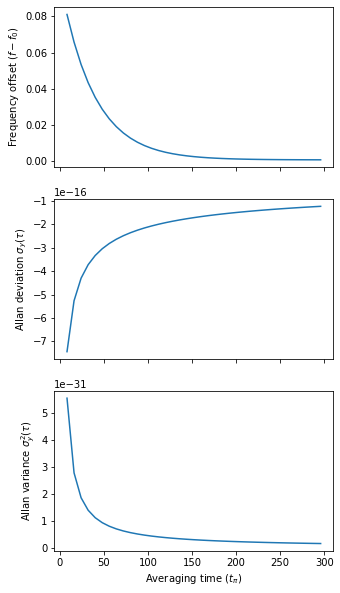

In [316]:
# main simulation loop
T_c = 8 # in tau_pis?
max_tau = 300
t = np.arange(start=T_c,stop=max_tau, step=T_c)
etas = np.zeros(len(t))
sigmas = np.zeros(len(t))
initial_offset = .1
state_preparation = True
tau_ls = 1 # t for lineshape
d, step = np.linspace(-2, 2, 1000, retstep=True)
without_offset = get_both_ps(d, lineshape, 10)
k_p = slope(lineshape, without_offset['x_R'], 10) # which side of lineshape to use?
p_X = 0.5 if state_preparation else 0.25
g = -2 * p_X / k_p # gain
f = initial_offset
laser_drift_per_timestep = 20e-6 * 2 * np.pi
for i in range(0, len(t)):
    tau = t[i]
    measurement = get_both_ps(d, lineshape, tau_ls, f) # do measurement
    f = f + correction_signal(2*g, measurement) + laser_drift_per_timestep # correct frequency
    etas[i] = f
    sigmas[i] = allan_deviation(p_X, k_p, T_c, tau)

fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(5, 10))
ax[0].plot(t, etas)
ax[0].set_ylabel(r"Frequency offset ($f-f_0$)")
ax[1].plot(t, sigmas)
ax[1].set_ylabel(r"Allan deviation $\sigma_y(\tau)$")
ax[2].plot(t, np.square(sigmas))
ax[2].set_ylabel(r"Allan variance $\sigma_y^2(\tau)$")
plt.xlabel(r'Averaging time ($t_\pi$)')

### Laser noise simulation
Cauchy distribution (how to translate into $\Omega_R$-space?), looks ok.

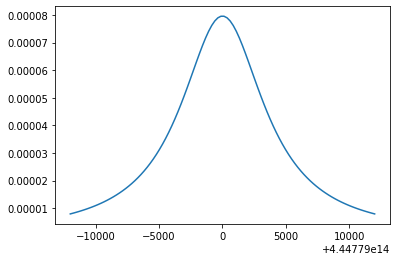

In [282]:
laser_lw = 4e3 #Hz, guess
eta0 = 444.779e12 # transition center
l = np.linspace(eta0 - 3*laser_lw, eta0 + 3*laser_lw, 100)
plt.plot(l, cauchy.pdf(l, loc=eta0, scale=laser_lw))

### Sampling function

(0.02, 252.252351252252)